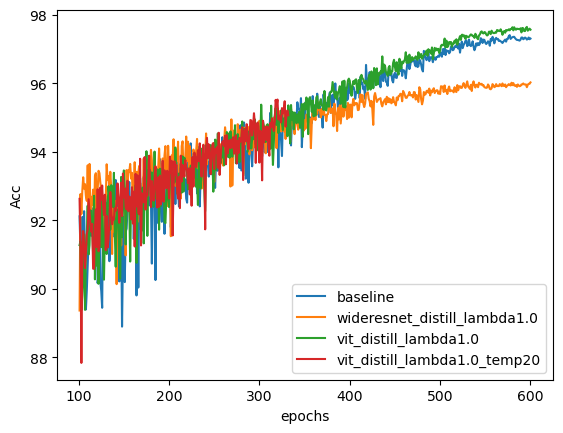

In [2]:
import matplotlib.pyplot as plt


retrain = "retrain_output/darts_cifar10/log.txt"
wideresnet_distill_1 = "retrain_output/darts_cifar10_distill_lambda0.1/log.txt"
wideresnet_distill_2 = "retrain_output/darts_cifar10_distill_lambda1.0/log.txt"
vit_distill_1 = "retrain_output/darts_cifar10_distill_vit_lambda0.1/log.txt"
vit_distill_2 = "retrain_output/darts_cifar10_distill_vit_lambda1.0/log.txt"
vit_distill_3 = "eval-EXP-20230711-071251/log.txt"

def load_test_acc_top1(file_path):
    test_acc_top1 = []
    with open(file_path) as f:
        for line in f.readlines():
            if "test_acc_top1" in line:
                test_acc_top1.append(float(line[-10:]))
    return test_acc_top1

retrain_acc_top1 = load_test_acc_top1(retrain)
wideresnet_distill_1_acc_top1 = load_test_acc_top1(wideresnet_distill_1)
wideresnet_distill_2_acc_top1 = load_test_acc_top1(wideresnet_distill_2)
vit_distill_1_acc_top1 = load_test_acc_top1(vit_distill_1)
vit_distill_2_acc_top1 = load_test_acc_top1(vit_distill_2)
vit_distill_3_acc_top1 = load_test_acc_top1(vit_distill_3)

xs = list(range(1, 602))
start = 100
end = 600
plt.plot(xs[start:end], retrain_acc_top1[start:end], label="baseline")
# plt.plot(xs[start:end], wideresnet_distill_1_acc_top1[start:end], label="wideresnet_distill_lambda0.1")
plt.plot(xs[start:end], wideresnet_distill_2_acc_top1[start:end], label="wideresnet_distill_lambda1.0")
# plt.plot(xs[start:end], vit_distill_1_acc_top1[start:end], label="vit_distill_lambda0.1")
plt.plot(xs[start:end], vit_distill_2_acc_top1[start:end], label="vit_distill_lambda1.0")
plt.plot(xs[start:min(len(vit_distill_3_acc_top1), end)], vit_distill_3_acc_top1[start:min(len(vit_distill_3_acc_top1), end)], label="vit_distill_lambda1.0_temp20")

plt.xlabel("epochs")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [39]:
import torch
import torch.nn as nn
from timm.models.layers import trunc_normal_, DropPath, to_2tuple
import math


class BlockDCT(nn.Module):
    def __init__(
        self,
        img_size: int = 896,
        patch_size: int = 4,
        # in_chans: int = 3,
        # embed_dim=48,
        # norm_layer: nn.Module = None,
        flatten: bool = False,
    ):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        self.img_size = img_size
        self.ps = patch_size
        self.flatten = flatten

        self.unfold = nn.Unfold(patch_size, stride=patch_size)
        # jpeg_chans = in_chans * patch_size[0] * patch_size[1]
        # if embed_dim != jpeg_chans:
        #     self.embed = nn.Conv2d(jpeg_chans, embed_dim, kernel_size=1)
        # self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

        self.harmonics = nn.Parameter(
            BlockDCT._harmonics(self.ps[0]), requires_grad=False
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # blockify
        N, C, H, W = x.shape
        h, w = H // self.ps[0], W // self.ps[1]
        x = x.view(N * C, 1, H, W)
        x = self.unfold(x).transpose(1, 2)
        x = x.view(N, C, h * w, self.ps[0], self.ps[1])
        # local dct
        x = self.dct(x, self.harmonics)
        # deblockify
        x = x.reshape(N * C, h * w, self.ps[0] * self.ps[1])
        x = x.transpose(1, 2)
        x = x.reshape(N, C * self.ps[0] * self.ps[1], h, w)

        # # channel embedding
        # x = self.embed(x)
        # x = self.norm(x)
        if self.flatten:
            x = x.flatten(2).transpose(1, 2)  # BCHW -> BNC
        return x

    @staticmethod
    def _harmonics(N: int) -> torch.Tensor:
        r"""
        Computes the cosine harmonics for the DCT transform
        """
        spectral = torch.arange(N, dtype=torch.float32).reshape((N, 1))
        spatial = spectral.clone().t()

        spectral = (spectral * math.pi) / (2 * N)
        spatial = 2 * spatial + 1
        harmonics = torch.cos(spectral @ spatial)

        norm = torch.full([N, 1], (2 / N) ** 0.5)
        norm[0, 0] /= 2**0.5
        return harmonics * norm

    def dct(self, image: torch.Tensor, harmonics) -> torch.Tensor:
        coeff = harmonics @ image @ harmonics.t()
        return coeff

    def idct(self, coeff: torch.Tensor, harmonics) -> torch.Tensor:
        image = harmonics.t() @ coeff @ harmonics
        return image


net = BlockDCT()
x = torch.rand(1, 3, 896, 896)
y = net(x)
y.shape

torch.Size([4, 4])


torch.Size([1, 48, 224, 224])

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import to_2tuple
import math


class DCTConv(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 1,
        stride: int = 1,
        padding: int = 0,
        flatten: bool = False,
    ):
        super().__init__()
        self.ks = kernel_size
        self.stride = stride
        self.padding = padding
        assert in_channels == out_channels, "Only support depthwise conv"
        self.groups = out_channels
        self.flatten = flatten

        harmonics = DCTConv._harmonics(kernel_size)
        prototype = harmonics.reshape(kernel_size, 1, kernel_size, 1) @ harmonics.reshape(1, kernel_size, 1, kernel_size)
        self.prototype = prototype.reshape(1, kernel_size ** 2, kernel_size, kernel_size)
        self.embed = nn.Conv2d(kernel_size ** 2, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        kernel = self.embed(self.prototype.to(x.device)).reshape(-1, 1, self.ks, self.ks)
        x = F.conv2d(x, kernel, stride=self.stride, padding=self.padding, groups=self.groups)

        if self.flatten:
            x = x.flatten(2).transpose(1, 2)  # BCHW -> BNC
        return x

    @staticmethod
    def _harmonics(N: int) -> torch.Tensor:
        r"""
        Computes the cosine harmonics for the DCT transform
        """
        spectral = torch.arange(N, dtype=torch.float32).reshape((N, 1))
        spatial = spectral.clone().t()

        spectral = (spectral * math.pi) / (2 * N)
        spatial = 2 * spatial + 1
        harmonics = torch.cos(spectral @ spatial)

        norm = torch.full([N, 1], (2 / N) ** 0.5)
        norm[0, 0] /= 2**0.5
        return harmonics * norm

    def dct(self, image: torch.Tensor, harmonics) -> torch.Tensor:
        coeff = harmonics @ image @ harmonics.t()
        return coeff

    def idct(self, coeff: torch.Tensor, harmonics) -> torch.Tensor:
        image = harmonics.t() @ coeff @ harmonics
        return image


net = DCTConv(in_channels=3, out_channels=3, kernel_size=3, padding=1)
x = torch.rand(2, 3, 3, 3)
y = net(x)
print(y.shape)

torch.Size([2, 3, 3, 3])


In [46]:
x = torch.rand(1, 1, 4, 4)
y = F.conv2d(x, torch.ones(16, 1, 4, 4))
y.shape

torch.Size([1, 16, 1, 1])